## Aula geração de textos com redes LSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
import pandas as pd
import re 
from keras.utils.data_utils import get_file
import tensorflow as tf, numpy as np
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical 
import io

import matplotlib.pyplot as plt
import string
plt.style.use('ggplot')

In [4]:
# Carregar os datasets
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
import pandas as pd
from gensim.models import KeyedVectors

auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [5]:
# Baixa os dados de treinamento
link = 'https://drive.google.com/file/d/17HvOhjpwWSNranjmcRJUQKLr124EBRAd/view?usp=sharing'
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('df_corpus.txt')

In [6]:
with open('df_corpus.txt') as f:
    df_corpus = f.readlines()

In [11]:
df_corpus[1]

'www.nead.unama.br      universidade da amazônia     a normalista   nead  núcleo de educação a distância     av. alcindo cacela, 287  umarizal          cep: 66060-902          belém  pará      fones: (91) 210-3196 / 210-3181         www.nead.unama.br        e-mail: uvb@unama.br                            1                                  www.nead.unama.br  a normalista de adolfo caminha   capítulo i     joão maciel da mata gadelha, conhecido em fortaleza por joão da mata, habitava, há anos, no trilho, uma casinhola de porta e janela, cor de açafrão, com a frente encardida pela fuligem das locomotivas que diariamente cruzavam defronte, e de onde se avistava a estação da linha férrea de baturité. era amanuense, amigado, e gostava de jogar víspora em família aos domingos.    nessa noite estavam reunidas as pessoas do costume. ao centro da sala, em torno de uma mesa coberta com um pano xadrez, à luz parca de um candeeiro de louça esfumado, em forma de abajur, corriam os olhos sobre as vel

In [12]:
# Elimina espaços, caracteres que não sejam letras, e concatena todas as palavras em um único corpus
for t in df_corpus:
    text_words = [w for w in str(df_corpus).split(' ') if w.strip() != '' or w == '\n']


text_words = [re.sub(r'[^\x00-\x7f]',r'', s) for s in text_words]
print('Quantidade Total de Palavras: ', len(text_words))
print(text_words[:10])

Quantidade Total de Palavras:  3775002
["['a", 'condessa', 'vsper', 'aluzio', 'azevedo', 'as', 'memrias', 'de', 'um', 'condenado']


In [13]:
# Definir vocabulário usado no modelo.
vocab_size = 50
# criando tokenizer (usa somente as 'VOCAB_SIZE' palavras mais comuns)
tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

# definindo vocabulario
tokenizer.fit_on_texts(text_words)
# tokenizando as palavras
tokens = tokenizer.texts_to_sequences(text_words)

In [15]:
y = []
for i in tokens:
  try:
    y.append(i[0])
  except:
    continue

In [16]:
tokens = y

print(text_words[:8])
print(tokens[:8])

["['a", 'condessa', 'vsper', 'aluzio', 'azevedo', 'as', 'memrias', 'de']
[18, 2, 9, 13, 26, 6, 8, 40]


In [17]:
# Após tokenizar as sentenças vamos agrupar as palavras criando sub-sequencias de entrada ***X*** e suas respectivas saidas, ou seja as palavras seguintes ***Y***.
# Quando fazemos esse slice, podemos definir um intervalo entre cada step, isso reduz a produção de sequencias com palavras sobrepostas e repetidas.

step = 1 # distancia a cada fatia 
sentences = [] # frases X
next_words = [] # palavras Y
seq_len = 10 # número de tokens por frase
for i in range(0, len(tokens) - seq_len, step):
    sentences.append(tokens[i: i + seq_len])
    next_words.append(tokens[i + seq_len])
   
print(f'[+] Instâncias para treino: {len(sentences)}')
for i in range(5):
    print(sentences[i],'-->',next_words[i])

[+] Instâncias para treino: 1550705
[18, 2, 9, 13, 26, 6, 8, 40, 38, 19] --> 13
[2, 9, 13, 26, 6, 8, 40, 38, 19, 13] --> 4
[9, 13, 26, 6, 8, 40, 38, 19, 13, 4] --> 3
[13, 26, 6, 8, 40, 38, 19, 13, 4, 3] --> 17
[26, 6, 8, 40, 38, 19, 13, 4, 3, 17] --> 44


In [18]:
# mostra shape atual
train_x = np.array(sentences) # pega as sentenças
train_y = np.array(next_words) # pega as palavras seguintes
print('Shape X:',train_x.shape)
print('Shape Y:',train_y.shape)

Shape X: (1550705, 10)
Shape Y: (1550705,)


In [19]:
# codificando para one-hot
train_x_onehot = to_categorical(train_x, num_classes=vocab_size)    
train_y_onehot = to_categorical(train_y, num_classes=vocab_size)
# train_x:(num_exemplos, num_tokens, vocab_size)
print('Shape X após one-hot:',train_x_onehot.shape)
# train_y:(num_exemplos,vocab_size)
print('Shape Y após one-hot:',train_y_onehot.shape)

Shape X após one-hot: (1550705, 10, 50)
Shape Y após one-hot: (1550705, 50)


In [20]:
# Modelo LSTM
model = keras.Sequential([
    layers.LSTM(256, input_shape=(seq_len, vocab_size), return_sequences=False,),
    layers.Dropout(0.2),
    layers.Dense(vocab_size, activation='softmax')
])

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               314368    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 50)                12850     
                                                                 
Total params: 327,218
Trainable params: 327,218
Non-trainable params: 0
_________________________________________________________________


In [23]:
train_history = model.fit(train_x_onehot, train_y_onehot, validation_split=0.2,
                    epochs=10, batch_size=512)

Epoch 1/10
2423/2423 [==============================] - 476s 196ms/step - loss: 3.2520 - accuracy: 0.1361 - val_loss: 3.2411 - val_accuracy: 0.1340
Epoch 2/10
2423/2423 [==============================] - 452s 187ms/step - loss: 3.2413 - accuracy: 0.1379 - val_loss: 3.2368 - val_accuracy: 0.1347
Epoch 3/10
2423/2423 [==============================] - 457s 189ms/step - loss: 3.2338 - accuracy: 0.1393 - val_loss: 3.2283 - val_accuracy: 0.1365
Epoch 4/10
2423/2423 [==============================] - 455s 188ms/step - loss: 3.2281 - accuracy: 0.1401 - val_loss: 3.2283 - val_accuracy: 0.1359
Epoch 5/10
2423/2423 [==============================] - 454s 187ms/step - loss: 3.2238 - accuracy: 0.1411 - val_loss: 3.2257 - val_accuracy: 0.1369
Epoch 6/10
2423/2423 [==============================] - 456s 188ms/step - loss: 3.2194 - accuracy: 0.1419 - val_loss: 3.2228 - val_accuracy: 0.1380
Epoch 7/10
2423/2423 [==============================] - 457s 188ms/step - loss: 3.2160 - accuracy: 0.1427 - val_

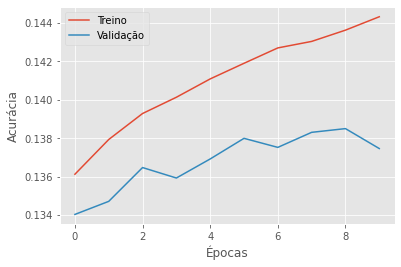

In [25]:
plt.plot(train_history.history['accuracy'], label='Treino')
plt.plot(train_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas');plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [26]:
import joblib 

joblib.dump(model, 'nlg_model.pkl')

INFO:tensorflow:Assets written to: ram://139ca1a9-38b4-4629-a569-06c1f47d00f3/assets


INFO:tensorflow:Assets written to: ram://139ca1a9-38b4-4629-a569-06c1f47d00f3/assets


['nlg_model.pkl']

In [27]:
seed_text = ['chuvas:'] # Palavra inicial
seed_tokens = tokenizer.texts_to_sequences(seed_text)[0] # substitui palavras por tokens
tokens_x = pad_sequences([seed_tokens], maxlen=seq_len, )
tokens_x = to_categorical(tokens_x, num_classes=vocab_size) # one hot
pred_y = model.predict(tokens_x)[0] # preve probabilidades para a proxima palavra
print(f'Quantidade de Probabilidades: {len(pred_y)}')
print(pred_y[:4])

Quantidade de Probabilidades: 50
[3.0829824e-07 1.0158990e-01 9.0438381e-02 8.3224289e-02]


In [28]:
# pega indice da palavra com maior probabilidade 
next_token = np.argmax(pred_y,)
# realiza a inversão de token para palavra
next_word = tokenizer.sequences_to_texts([[next_token]])
print('Proximo token: ', next_token, '-->', next_word)

Proximo token:  1 --> ['a']


In [29]:
def sample_word(pred_y, temperature=1.0):
    pred_y = pred_y / temperature # 'força' das probabilidades
    pred_token = tf.random.categorical(pred_y, 1).numpy()
    return pred_token # token de saída

def text_predict(token, qtd_words):

    seed_text = token # frase inicial
    next_words = qtd_words # 100 próximas palavras
    # substitui palavras por tokens
    seed_tokens = tokenizer.texts_to_sequences(seed_text)[0] # substitui palavras por tokens
    print(seed_text, ' tokenizado fica: ', seed_tokens)
    for _ in range(next_words):
        # preenche sequencia com zeros para ter o comprimento adequado pra rede
        tokens_x = pad_sequences([seed_tokens], maxlen=seq_len, )
        # transforma tokens em vetor one-hot
        tokens_x = to_categorical(tokens_x, num_classes=vocab_size) # one hot
        # preve probabilidades para a proxima palavra
        pred_y = model.predict(tokens_x)
        # faz amostragem com base nas probabilidades
        next_token = sample_word(pred_y, 0.2)
        next_token = next_token.flatten()[0] # pega valor como um int
        # anexa token a lista
        seed_tokens.append(next_token) 
        
    # como a saída é um conjunto de tokens
    # realiza a inversão para palavras, usando word_index
    resultado = tokenizer.sequences_to_texts([seed_tokens])
    print('\n')
    return resultado[0]

In [30]:
text_predict('Universidade', 50)

Universidade  tokenizado fica:  []




'ou tinha com ser na de e uma minha seu da me da da ainda da muito mas no j minha uma disse minha ela das sua em ela que mas as ou foi com o do as o um as ser disse e como meu sua ou'